In [1]:
import time
start_time = time.time()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
import dendrotweaks as dd
dd.__version__

'0.5.0'

In [4]:
dd.apply_dark_theme() # Set the theme for the plots

In [5]:
path_to_model = os.getcwd()
print(f'Path to model: {path_to_model}')
path_to_data = os.path.dirname(path_to_model)
print(f'Path to data: {path_to_data}')

Path to model: /home/roman/Documents/code/DendroTweaksLab/DendroTweaks/examples/Park_2019
Path to data: /home/roman/Documents/code/DendroTweaksLab/DendroTweaks/examples


In [6]:
model = dd.Model(path_to_model)

# Morphology

We will proceed by loading the morphology of the cell from an SWC file. First, we list the available morphologies in the morphology subfolder.

In [7]:
model.list_morphologies()

['Park_2019_reduced_apic',
 'Park_2019_sorted',
 'Park_2019_target_branch',
 'Park_2019']

We can load a specific morphology using the load_morphology method.

In [8]:
model.load_morphology(file_name='Park_2019')

Sorted PointTree(root=Point(idx=0), num_nodes=2214).
Extended 44 nodes.
Sorted PointTree(root=Point(idx=0), num_nodes=2258).


We now have access to point_tree, sec_tree and seg_tree attributes of the model object.

In [9]:
model.point_tree, model.sec_tree, model.seg_tree

(PointTree(root=Point(idx=0), num_nodes=2258),
 SectionTree(root=NeuronSection(idx=0), num_nodes=52),
 SegmentTree(root=NeuronSegment(idx=0), num_nodes=124))

We can visualize the morphology using the `plot` method:

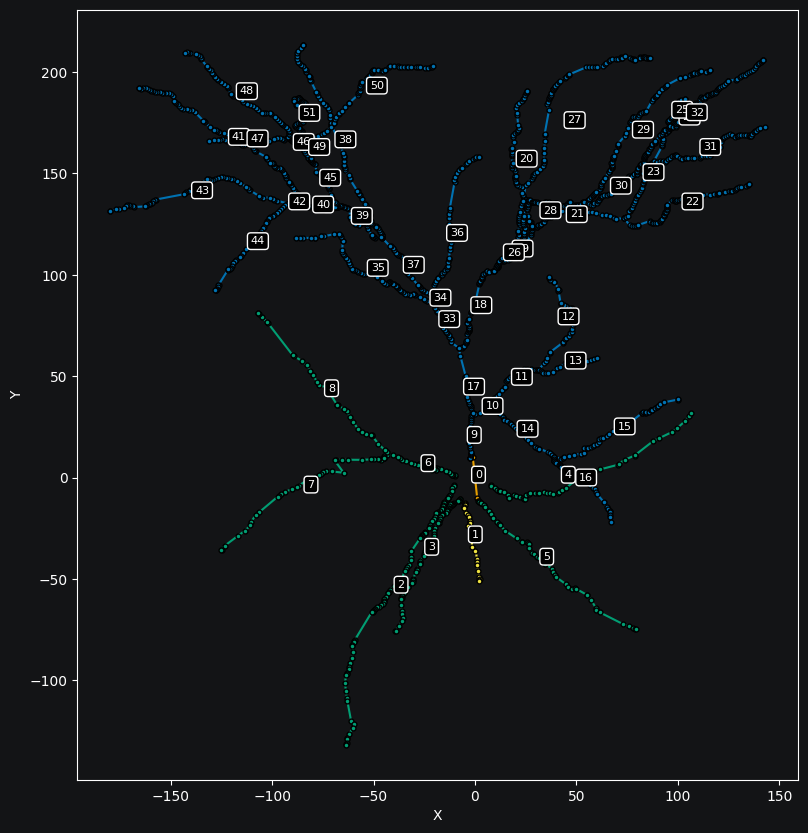

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
model.sec_tree.plot(ax, 
                    show_points=True,
                    show_lines=True,
                    annotate=True)

In [11]:
model.export_morphology(file_name='Park_2019_sorted')

Removed 44 overlapping nodes.
Sorted PointTree(root=Point(idx=0), num_nodes=2214).
Extended 44 nodes.
Sorted PointTree(root=Point(idx=0), num_nodes=2258).


We can calculate some important morphometric statistics with the following function from the analysis subpackage.

In [12]:
from dendrotweaks.analysis import calculate_domain_statistics

In [13]:
calculate_domain_statistics(model, domain_names=['apic', 'soma'])

{'apic': {'N_sections': 43,
  'N_bifurcations': 21,
  'N_terminations': 22,
  'depth': {'min': 1,
   'max': 8,
   'counts': {1: 1, 2: 2, 3: 4, 4: 8, 5: 8, 6: 6, 7: 8, 8: 6}},
  'diam': {'min': 0.38, 'max': 2.06, 'mean': 0.82, 'std': 0.45},
  'length': {'min': 4.51, 'max': 154.69, 'mean': 58.31, 'std': 35.75},
  'area': {'min': 17.6, 'max': 271.28, 'mean': 130.52, 'std': 74.2},
  'total_length': 2507.17,
  'total_area': 5612.19},
 'soma': {'N_sections': 1,
  'N_bifurcations': 0,
  'N_terminations': 0,
  'depth': {'min': 0, 'max': 0, 'counts': {0: 1}},
  'diam': {'min': 20.44, 'max': 20.44, 'mean': 20.44, 'std': nan},
  'length': {'min': 20.44, 'max': 20.44, 'mean': 20.44, 'std': nan},
  'area': {'min': 1312.27, 'max': 1312.27, 'mean': 1312.27, 'std': nan},
  'total_length': 20.44,
  'total_area': 1312.27}}

## Segmentation

In [14]:
model.set_param('cm', value=2)
model.set_param('cm', group_name='somatic', value=1)
model.set_param('Ra', value=100)

In [15]:
model.set_segmentation(d_lambda=0.1)
len(model.seg_tree)

246

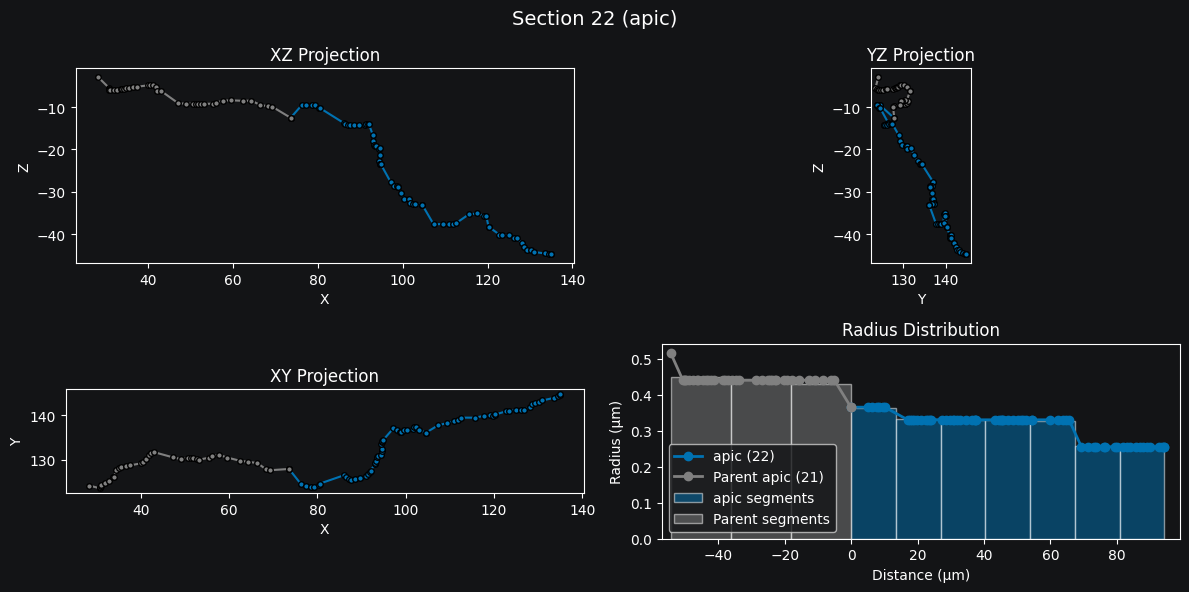

In [16]:
sec = model.sec_tree[22]
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
sec.plot(ax=ax, plot_parent=True)
plt.tight_layout()

# Membrane mechanisms

After defining the neuronal morphology, we now need to specify its biophysical properties. The biophysical properties of our model depend on the mechanisms present in the membrane. These mechanisms are defined in MOD files as sets of equations and parameters, which are compiled and loaded into NEURON.

## Adding mechanisms

First, let’s add the default mechanisms to the model, which include the leak channel, calcium dynamics and synaptic mechanisms:

In [17]:
model.list_biophys()

['Park_2019_remove_Na_from_branch', 'Park_2019_reduced_apic', 'Park_2019_full']

In [18]:
model.verbose = True

In [19]:
model.add_default_mechanisms(recompile=True)

Loading mechanism vecstim to NEURON...
Compiling mechanism "vecstim"...
Compilation successful.
/home/roman/Documents/code/DendroTweaksLab/DendroTweaks/examples/Default/vecstim
Mod files: "./vecstim.mod"

Creating 'x86_64' directory for .o files.

 -> Compiling mod_func.cpp
 -> NMODL ../vecstim.mod
 -> Compiling vecstim.c
 => LINKING shared library ./libnrnmech.so
 => LINKING executable ./special LDFLAGS are:    -pthread
Successfully created x86_64/special

Loaded mechanism "vecstim"
Loading mechanism AMPA_NMDA to NEURON...
Compiling mechanism "AMPA_NMDA"...
Compilation successful.
/home/roman/Documents/code/DendroTweaksLab/DendroTweaks/examples/Default/AMPA_NMDA
Mod files: "./AMPA_NMDA.mod"

Creating 'x86_64' directory for .o files.

 -> Compiling mod_func.cpp
 -> NMODL ../AMPA_NMDA.mod
 -> Compiling AMPA_NMDA.c
 => LINKING shared library ./libnrnmech.so
 => LINKING executable ./special LDFLAGS are:    -pthread
Successfully created x86_64/special

Loaded mechanism "AMPA_NMDA"
Loading 

However, for most of the models, we need to add user-defined mechanisms. We can create a mechanism object from a MOD file using the add_mechanism method. For example, let’s add the sodium and potassium channels to the model. We can list the available mechanisms in the mod directory:

In [20]:
model.list_mechanisms()

['stdNa', 'Na', 'stdKv', 'KCa', 'Kv', 'Ka', 'CaHVA', 'Km', 'CaLVA']

Next, we will add these user-defined mechanisms to the model:

In [21]:
for mech_name in ['CaHVA', 'CaLVA', 'KCa', 'Ka', 'Km', 'Kv', 'Na']:
    model.add_mechanism(mech_name, recompile=True)

Saved content to /home/roman/Documents/code/DendroTweaksLab/DendroTweaks/examples/Park_2019/biophys/python/CaHVA.py
Loading mechanism CaHVA to NEURON...
Compiling mechanism "CaHVA"...
Compilation successful.
/home/roman/Documents/code/DendroTweaksLab/DendroTweaks/examples/Park_2019/biophys/mod/CaHVA
Mod files: "./CaHVA.mod"

Creating 'x86_64' directory for .o files.

 -> Compiling mod_func.cpp
 -> NMODL ../CaHVA.mod
 -> Compiling CaHVA.c
 => LINKING shared library ./libnrnmech.so
 => LINKING executable ./special LDFLAGS are:    -pthread
Successfully created x86_64/special

Loaded mechanism "CaHVA"
Saved content to /home/roman/Documents/code/DendroTweaksLab/DendroTweaks/examples/Park_2019/biophys/python/CaLVA.py
Loading mechanism CaLVA to NEURON...
Compiling mechanism "CaLVA"...
Compilation successful.
/home/roman/Documents/code/DendroTweaksLab/DendroTweaks/examples/Park_2019/biophys/mod/CaLVA
Mod files: "./CaLVA.mod"

Creating 'x86_64' directory for .o files.

 -> Compiling mod_func.cp

With these commands, we create Python objects from MOD files and add them to mechanisms. We also compile and load the MOD files, making them available in NEURON.

To see all mechanisms available in the model, we can use the mechanisms attribute.

In [22]:
model.mechanisms

{'Leak': <Mechanism(Leak)>,
 'CaDyn': <Mechanism(CaDyn)>,
 'CaHVA': <Mechanism(CaHVA)>,
 'CaLVA': <Mechanism(CaLVA)>,
 'KCa': <Mechanism(KCa)>,
 'Ka': <Mechanism(Ka)>,
 'Km': <Mechanism(Km)>,
 'Kv': <Mechanism(Kv)>,
 'Na': <Mechanism(Na)>}

Each mechanism object is an instance of the Mechanism class, which contains information about the mechanism, such as its name and parameters. To examine the parameters of a specific mechanism, we can use the params attribute:

In [23]:
model.mechanisms['Leak'].params

{'gbar': 0.0, 'e': -70}

Note that the parameters stored within the mechanisms are the default values from the MOD files. The actual values of the parameters used for the simulation are stored in the model object!

We can view the global parameters of the model with the params attribute:

In [24]:
model.params

{'cm': {'all': constant({'value': 2}), 'somatic': constant({'value': 1})},
 'Ra': {'all': constant({'value': 100})}}

We should interpret the output as follows: the specific membrane capacitance cm is set to a constant value of 2 $\mu F/cm^2$ for all segments of the cell apart from the soma, where it is set to 1 $\mu F/cm^2$.
The axial resistance Ra is set to 35.4 $Ohm \cdot cm$
 for all segments of the cell. We will discuss how to update these parameters shortly.

Note that so far we have only loaded the mechanisms without actually inserting them into the membrane. Therefore, the parameters of these mechanisms are not yet included in the `model.params` dictionary. In the next step, we will insert the mechanisms into the membrane.

## Inserting mechanisms to specific domains

In DendroTweaks, membrane mechanisms are mapped to morphological domains. A domain is a region of a neuron distinguished by its anatomical or functional properties. In a typical pyramidal cell model we have the following domains: soma, axon, basal dendrites, apical dendrite (further subdivided into trunk, tuft, and oblique dendrites).

In DendroTweaks, a domain represents a collection of sections that share the same properties. We can view the domains of the model with the `domains` attribute.

In [25]:
model.domains

{'apic': <Domain(apic, 4, #0072B2, 43 sections)>,
 'axon': <Domain(axon, 2, #F0E442, 1 sections)>,
 'dend': <Domain(dend, 3, #019E73, 7 sections)>,
 'soma': <Domain(soma, 1, #E69F00, 1 sections)>}

After uploading the mechanisms in the previous step, we now need to insert them into specific domains. In this example, we insert each of the three available mechanisms to all domains. However, we could selectively insert mechanisms to specific domains, such as the soma or apical dendrite.

In [26]:
for domain_name in model.domains:
    if domain_name == 'axon':
        model.insert_mechanism('Leak', 'axon', distribute=False)
        continue
    for mech_name in model.mechanisms:
        model.insert_mechanism(mech_name, domain_name, distribute=False)

We can verify which mechanisms are inserted in each domain with the `domains_to_mechs` attribute.

In [27]:
model.domains_to_mechs

{'apic': {'CaDyn', 'CaHVA', 'CaLVA', 'KCa', 'Ka', 'Km', 'Kv', 'Leak', 'Na'},
 'axon': {'Leak'},
 'dend': {'CaDyn', 'CaHVA', 'CaLVA', 'KCa', 'Ka', 'Km', 'Kv', 'Leak', 'Na'},
 'soma': {'CaDyn', 'CaHVA', 'CaLVA', 'KCa', 'Ka', 'Km', 'Kv', 'Leak', 'Na'}}

To examine the parameters of the inserted mechanisms, we can use the `mechs_to_params` attribute.

In [28]:
model.mechs_to_params

{'Independent': ['cm', 'Ra', 'eca', 'ek', 'ena'],
 'Leak': ['gbar_Leak', 'e_Leak'],
 'CaDyn': ['depth_CaDyn',
  'taur_CaDyn',
  'cainf_CaDyn',
  'gamma_CaDyn',
  'kt_CaDyn',
  'kd_CaDyn'],
 'CaHVA': ['gbar_CaHVA'],
 'CaLVA': ['gbar_CaLVA'],
 'KCa': ['gbar_KCa'],
 'Ka': ['gbar_Ka'],
 'Km': ['gbar_Km', 'v12_Km', 'q_Km'],
 'Kv': ['gbar_Kv', 'v12_Kv', 'q_Kv'],
 'Na': ['gbar_Na',
  'Rma_Na',
  'Rmb_Na',
  'v12m_Na',
  'qm_Na',
  'Rhb_Na',
  'Rha_Na',
  'v12ha_Na',
  'v12hb_Na',
  'qh_Na',
  'v12hinf_Na',
  'qhinf_Na']}

Some parameters, such as specific membrane capacitance `cm` and axial resistance `Ra`, do not belong to any mechanism. These independent parameters are grouped under an “Independent” pseudo-mechanism for interface consistency. These parameters are available in each domain by default.

At this point, we have inserted the mechanisms into the membrane and set the default parameters for the model. We can inspect the parameters of the inserted mechanisms using the `params` attribute.

In [29]:
model.df_params

,Mechanism,Parameter,Group,Distribution,Distribution params
0,Independent,cm,all,constant,{'value': 2}
1,Independent,cm,somatic,constant,{'value': 1}
2,Independent,Ra,all,constant,{'value': 100}
3,Independent,eca,all,constant,{'value': 140}
4,Independent,ek,all,constant,{'value': -77}
5,Independent,ena,all,constant,{'value': 50}
6,Leak,gbar_Leak,all,constant,{'value': 0.0}
7,Leak,e_Leak,all,constant,{'value': -70}
8,CaDyn,depth_CaDyn,all,constant,{'value': 0.1}
9,CaDyn,taur_CaDyn,all,constant,{'value': 80}


As we can see, all parameters are set to their default values across all segments of the cell, with some parameters initialized to 0.0. Before running the simulation, we need to set these parameters to more realistic values, which we will learn how to do in the next step.

# Model parameters

In real neurons, properties such as ion channel density vary across different regions of the cell. To distribute parameters across the cell, we need to specify where and how the parameter will be distributed.

## Defining segment groups

To select the segments where a given distribution will be applied, we use segment groups. A segment group is a collection of segments that meet certain criteria, such as the diameter or distance from the soma.

In [30]:
model.groups

{'all': SegmentGroup("all", domains=['apic', 'axon', 'dend', 'soma']),
 'apical': SegmentGroup("apical", domains=['apic']),
 'axonal': SegmentGroup("axonal", domains=['axon']),
 'dendritic': SegmentGroup("dendritic", domains=['dend']),
 'somatic': SegmentGroup("somatic", domains=['soma'])}

In [31]:
model.add_group(
    'dendritic_thin', domains=['dend', 'apic'],
    select_by='section_diam', max_value=0.8
)
model.add_group(
    'dendritic_thick', domains=['dend', 'apic'],
    select_by='section_diam', min_value=0.8
)

model.add_group(
    'proximal_apical', domains=['apic'],
    select_by='distance', max_value=260
)
model.add_group(
    'distal_apical', domains=['apic'],
    select_by='distance', min_value=260
)

model.add_group('basal', domains=['dend'])

model.add_group('dendritic', domains=['dend', 'apic'])

Adding group dendritic_thin...
Adding group dendritic_thick...
Adding group proximal_apical...
Adding group distal_apical...
Adding group basal...
Adding group dendritic...


## Distributing ion channels

To define how the parameter will be distributed, we use distribution functions. A distribution function takes a segment’s distance from the soma as input and returns the parameter value at that distance.

We can set the values of the parameters for the mechanisms inserted in the model using the set_param method, specifying the group name and the distribution type.

In [32]:
# Leak
Rm = 11000
model.set_param('gbar_Leak', value=1/Rm)

# Na
model.set_param('gbar_Na', group_name='somatic', value=0.0505)
model.set_param('gbar_Na', group_name='dendritic', value=0.0303)

# # Kv
model.set_param('gbar_Kv', group_name='somatic', value=0.005)
model.set_param('gbar_Kv', group_name='dendritic', value=0.000_15)

# # Km
model.set_param('gbar_Km', group_name='somatic', value=0.0002794)
model.set_param('gbar_Km', group_name='dendritic', value=0.000127)

# Ka
model.set_param('gbar_Ka', group_name='somatic', value=0.0054)
model.set_param('gbar_Ka', group_name='dendritic_thin', value=0.108)
model.set_param('gbar_Ka', group_name='dendritic_thick', value=0.0108)

# Kca
model.set_param('gbar_KCa', group_name='somatic', value=0.000_21)
model.set_param('gbar_KCa', group_name='dendritic', value=0.000_21)

#CaHVA
model.set_param('gbar_CaHVA', group_name='somatic', value=0.000_005)
model.set_param('gbar_CaHVA', group_name='basal', 
    distr_type='linear', slope=0.000_000_01, intercept=0.000_005)
model.set_param('gbar_CaHVA', group_name='proximal_apical', 
    distr_type='sinusoidal', amplitude=0.000_004923, frequency=0.008758, phase=0.8656)
model.set_param('gbar_CaHVA', group_name='distal_apical', value=0.000_002)

# CaLVA
model.set_param('gbar_CaLVA', group_name='somatic', value=0.000_03)
model.set_param('gbar_CaLVA', group_name='basal', 
    distr_type='linear', slope=0.000_000_06, intercept=0.000_03)
model.set_param('gbar_CaLVA', group_name='proximal_apical', 
    distr_type='sinusoidal', amplitude=0.000_029538, frequency=0.008758, phase=0.8656)
model.set_param('gbar_CaLVA', group_name='distal_apical', value=0.000_012)

In [33]:
model.set_param('depth_CaDyn', value=0.1)
model.set_param('taur_CaDyn', value=50)
model.set_param('cainf_CaDyn', value=1e-4)
model.set_param('gamma_CaDyn', value=1)
model.set_param('kt_CaDyn', value=0)
model.set_param('kd_CaDyn', value=0)

We can visualize the distribution of ion channels conductances in our model as a function of distance from the soma:

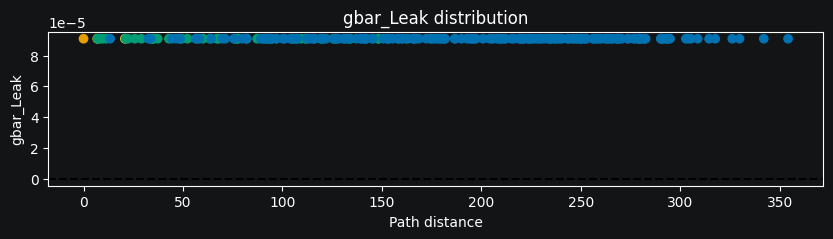

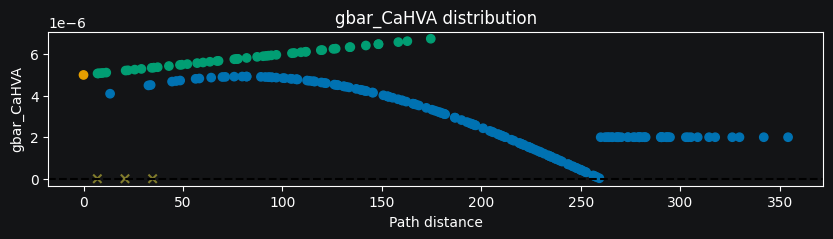

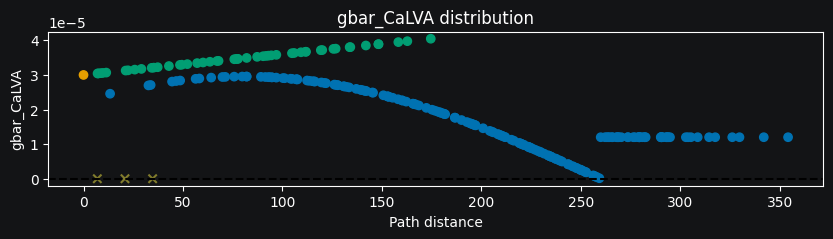

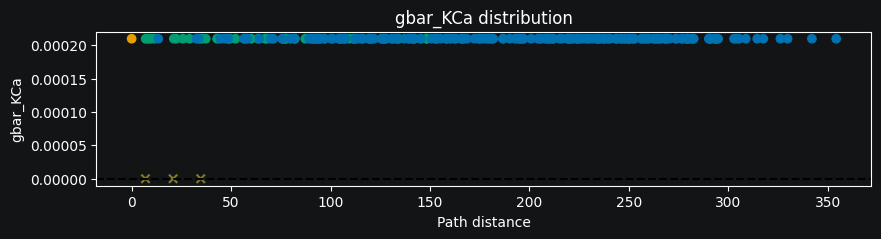

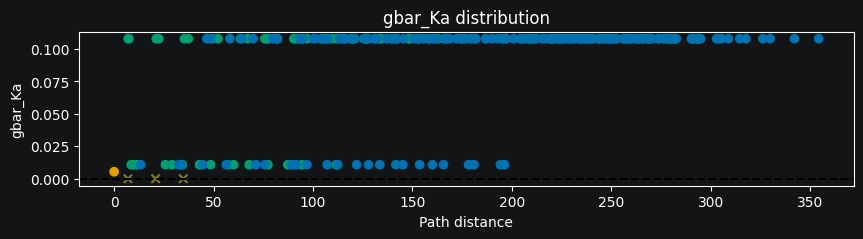

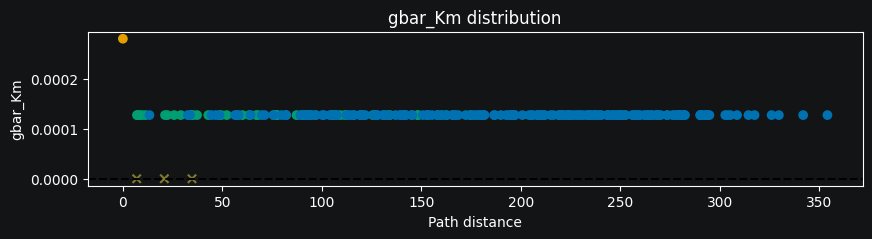

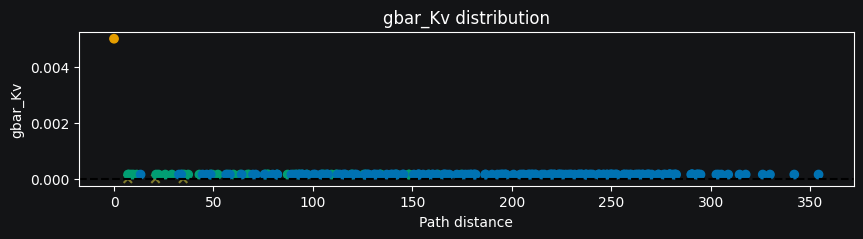

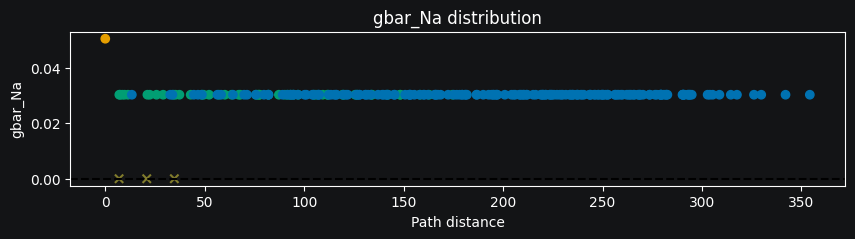

In [34]:
for param_name in model.conductances:
    fig, ax = plt.subplots(figsize=(10, 2))
    model.plot_param(param_name, ax=ax)

We can also set other parameters, such as reversal potentials, temperature, and initial membrane potential.

In [35]:
model.set_param('e_Leak', value=-79)
if 'ena' in model.params:
    model.set_param('ena', value=60)
if 'ek' in model.params:
    model.set_param('ek', value=-80)
if 'eca' in model.params:
    model.set_param('eca', value=140)
model.set_param('temperature', value=37)
model.set_param('v_init', value=-79)

In [36]:
# model.distribute_all()

Now, we can access the model parameters again and see that the values have been updated.

In [37]:
model.df_params

,Mechanism,Parameter,Group,Distribution,Distribution params
0,Independent,cm,all,constant,{'value': 2}
1,Independent,cm,somatic,constant,{'value': 1}
2,Independent,Ra,all,constant,{'value': 100}
3,Independent,eca,all,constant,{'value': 140}
4,Independent,ek,all,constant,{'value': -80}
5,Independent,ena,all,constant,{'value': 60}
6,Leak,gbar_Leak,all,constant,{'value': 9.09090909090909e-05}
7,Leak,e_Leak,all,constant,{'value': -79}
8,CaDyn,depth_CaDyn,all,constant,{'value': 0.1}
9,CaDyn,taur_CaDyn,all,constant,{'value': 50}


In [38]:
model.export_biophys(file_name='Park_2019_full')

# Simulation and analysis

We will learn how to simulate neuronal activity by applying a current stimulus and adding synapses to the neuron model and recording its response. This process mimics experimental electrophysiology where researchers inject current into neurons to study their firing properties. We will add a current clamp stimulus to the soma and record the somatic membrane potential.

In [39]:
from dendrotweaks.analysis import detect_somatic_spikes, plot_somatic_spikes
from dendrotweaks.analysis import calculate_passive_properties, plot_passive_properties

Let's first create a new variable for easy access to the soma

In [40]:
soma = model.sec_tree[0]
soma

NeuronSection(idx=0)

## Passive membrane properties

We will first examine the passive properties of our cell such as the input resistance $R_{in}$ and the membrane time constant $\tau_m$.

To observe the neuron’s activity, we need to place a recording electrode at a specific location:

We add a recording point at the center of the soma. The `loc` parameter specifies the location along the section where the recording will be placed. It is a normalized length, with 0.0 representing the start of the section and 1.0 representing the end.

In [41]:
model.add_recording(soma, loc=0.5, var='v')

Recording added to sec NeuronSection(idx=0) at loc 0.5.


Now we will apply a hyperpolarizing current step stimulus to change the membrane potential of the neuron.
We specify the duration of the stimulus in ms, the delay before the stimulus starts, and the amplitude of the stimulus in nanoamperes.

In [42]:
model.add_iclamp(soma, loc=0.5, amp=-0.01, delay=50, dur=900)

IClamp added to sec NeuronSection(idx=0) at loc 0.5.


With our recording and stimulus in place, we can now run the simulation:

In [43]:
model.simulator.run(1000); #ms

This runs the simulation for 1000 milliseconds (1 second). After the simulation completes, the voltage data is stored in simulator.vs and the corresponding time points in simulator.t.

Now, we can plot the resultant voltage trace of the simulation.

Input resistance: 119.15 MOhm
Time constant 17.94 ms. Estimated from double exp fit (slowest component)


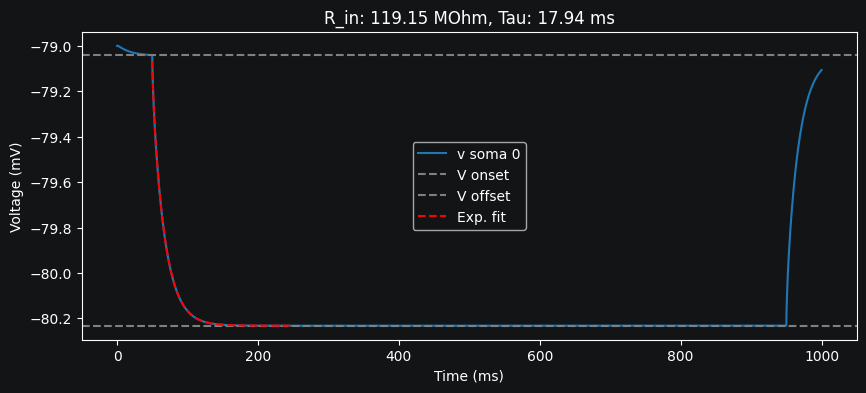

In [44]:
fig, ax = plt.subplots(figsize=(10, 4))
model.simulator.plot_var(var='v', ax=ax)
data = calculate_passive_properties(model)
plot_passive_properties(data, ax=ax)

We can export the stimulation protocol (i.e. the recordings and iclamps that we have added so far) using the following method, to reuse them in the future:

In [45]:
model.export_stimuli(file_name='hyperpolarizing_current')

The stimulation protocol that we used is now saved as an CSV and JSON files in the `data/Park_2019/stimuli/` folder. The JSON file defines the properties of the stimuli, while the CSV file defines their locations.

In [46]:
model.list_stimuli()

['50_AMPA_apical',
 'attenuation_dendritic',
 'hyperpolarizing_current',
 'depolarizing_current']

## Somatic spikes

Next, let's examine somatic action potentials. For this we will inject depolarizing current step at the soma and record the somatic voltage.

In [47]:
model.remove_all_stimuli()
model.remove_all_recordings()

model.add_recording(soma, loc=0.5)
model.add_iclamp(soma, loc=0.5, amp=0.162, delay=50, dur=900)

Recording added to sec NeuronSection(idx=0) at loc 0.5.
IClamp added to sec NeuronSection(idx=0) at loc 0.5.


We will use `detect_somatic_spikes` function from the `analysis` subpackage to identify the peaks and some other properties of the action potentials.

In [48]:
model.add_recording(loc=0.5, sec=soma, var='i_Kv')
model.add_recording(loc=0.5, sec=soma, var='i_Na')

Recording added to sec NeuronSection(idx=0) at loc 0.5.
Recording added to sec NeuronSection(idx=0) at loc 0.5.


Detected 7 spikes
Average spike half-width: 0.97 ms
Average spike amplitude: 79.03 mV
Spike frequency: 7.78 Hz


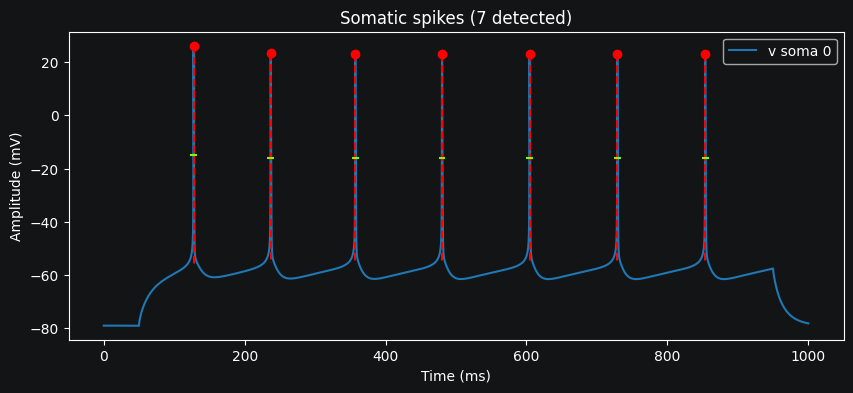

In [49]:
model.simulator.run(1000);

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
model.simulator.plot_voltage(ax=ax)
spike_data = detect_somatic_spikes(model)
plot_somatic_spikes(spike_data, ax, show_metrics=True)

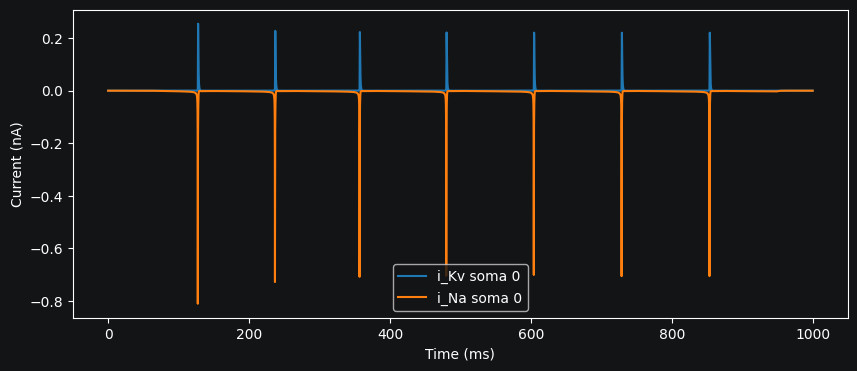

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
model.simulator.plot_currents(ax=ax)
# plt.xlim(120, 135)

In [51]:
model.export_stimuli(file_name='depolarizing_current')

## Frequency-current (f-I) relationship

A key characteristic of neurons is how their firing rate changes with input strength. The frequency-current (f-I) relationship helps identify the neuron’s computational properties and cell type.

We already have a somatic recording and a current clamp at the place. Let’s use a built-in protocol that will run simulations for a range of specified current amplitudes to measure this relationship:

In [52]:
from dendrotweaks.analysis import calculate_fI_curve, plot_fI_curve 

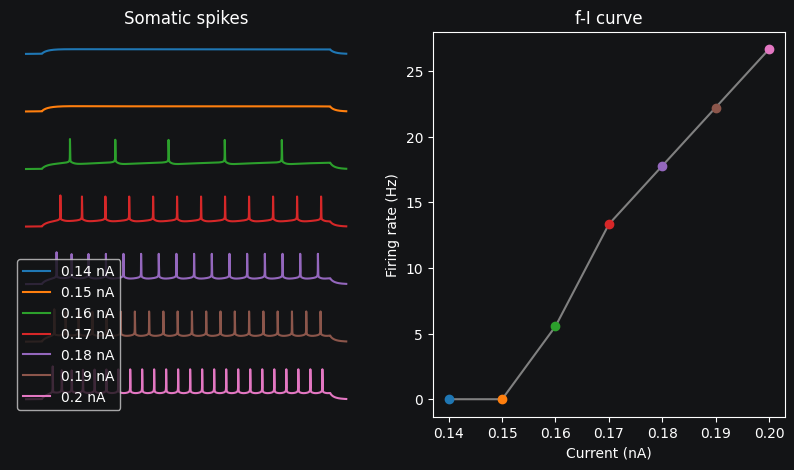

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fi_data = calculate_fI_curve(model, min_amp=0.14, max_amp=0.2, n=7)
plot_fI_curve(fi_data, ax) # should take about 40 seconds

## Synapses

Now let's place some AMPA synapses on the apical tree of our neuron. For this we will create a Population object that represents a population of "virtual" neurons that project to our neuron. To create a population we need to specify the type (AMPA) and the number of synapses to be formed and the segments of the model where they will be randomly distributed. We can then update the input parameters such as rate of incoming inputs and kinetic parameters such as rise and decay time constants.

In [54]:
model.remove_all_stimuli()
model.remove_all_recordings()

model.add_recording(soma, loc=0.5)

segments = model.get_segments(['apical'])
model.add_population(
    'excitatory',
    segments, 
    N=50, 
    syn_type='AMPA'
)
model.update_population_input_params('excitatory', rate=30, end=800, noise=1, seed=42)
model.update_population_kinetic_params('excitatory', tau_rise=0.1, tau_decay=2.5)

Recording added to sec NeuronSection(idx=0) at loc 0.5.
{'rate': 30, 'noise': 1, 'start': 100, 'end': 800, 'weight': 1, 'delay': 0, 'seed': 42}
{'gmax': 0.001, 'tau_rise': 0.1, 'tau_decay': 2.5, 'e': 0}


<Axes: xlabel='Time (ms)', ylabel='Voltage (mV)'>

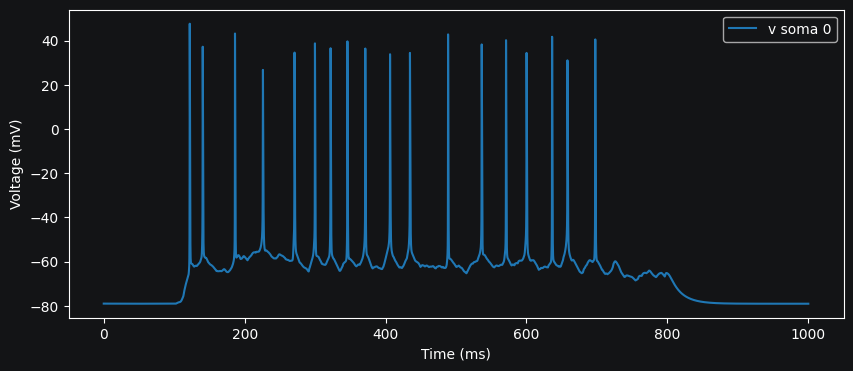

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
model.run(1000)
model.simulator.plot_var('v', ax=ax)

We can visualize the spike times of the pre-synaptic "virtual" neurons with the following code:

Text(0.5, 1.0, 'AMPA Synaptic Activity')

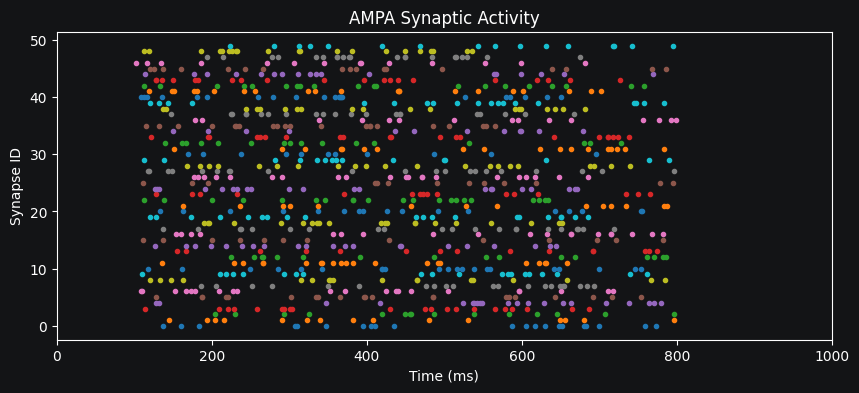

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
spike_times = model.populations['excitatory'].spike_times
for i, (syn, times) in enumerate(spike_times.items()):
    ax.plot(times, np.ones_like(times) * i, '.')

ax.set_xlim(0, 1000)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Synapse ID')
ax.set_title('AMPA Synaptic Activity')

In [57]:
model.export_stimuli(file_name='50_AMPA_apical')

In [58]:
model.populations

{'excitatory': <Population(excitatory, N=50)>}

## Voltage attenuation in dendrites

Next, we will explore passive and active properties of dendries. We will start by evaluating how a stimulus amplitude attenuates as the signal propagates from a dendrite to the soma. For this we will record the activity from several locations along a path from the soma to the tip of the apical dendrite.

In [59]:
from dendrotweaks.analysis import calculate_voltage_attenuation, plot_voltage_attenuation

In [60]:
model.remove_all_stimuli()
model.remove_all_recordings()

secs = [model.sec_tree[i] for i in [0, 9, 17, 18, 21, 22]]
for sec in secs:
    model.add_recording(sec, loc=0.5, var='v')

model.add_iclamp(secs[-1], loc=0.5, amp=-0.01, delay=100, dur=800)

Recording added to sec NeuronSection(idx=0) at loc 0.5.
Recording added to sec NeuronSection(idx=9) at loc 0.5.
Recording added to sec NeuronSection(idx=17) at loc 0.5.
Recording added to sec NeuronSection(idx=18) at loc 0.5.
Recording added to sec NeuronSection(idx=21) at loc 0.5.
Recording added to sec NeuronSection(idx=22) at loc 0.5.
IClamp added to sec NeuronSection(idx=22) at loc 0.5.


<Axes: xlabel='Time (ms)', ylabel='Voltage (mV)'>

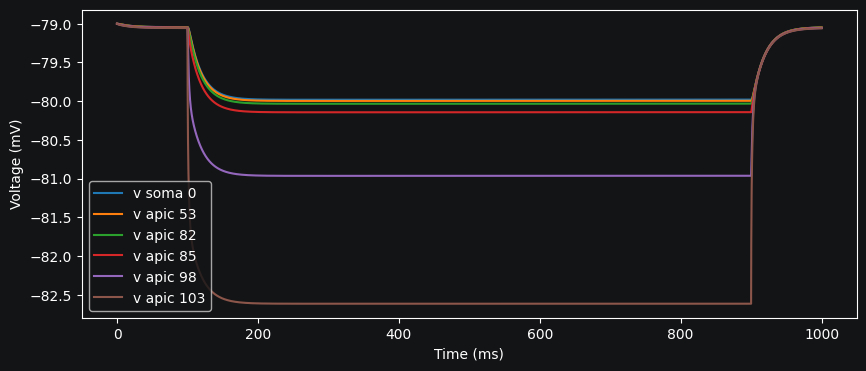

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
model.run(1000)
model.simulator.plot_var('v', ax=ax)

We will use `calculate_voltage_attenuation` to calculate how the voltage deflection from the resting membrane potential drops as we move further from the injection site at the dendrite.

Stimulating segment: NeuronSegment(idx=103)
Recording segments: [NeuronSegment(idx=0), NeuronSegment(idx=53), NeuronSegment(idx=82), NeuronSegment(idx=85), NeuronSegment(idx=98), NeuronSegment(idx=103)]


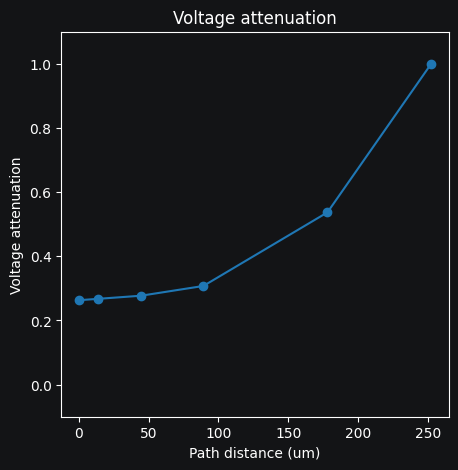

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
attenuation_data = calculate_voltage_attenuation(model)
plot_voltage_attenuation(attenuation_data, ax)

In [63]:
model.export_stimuli(file_name='attenuation_dendritic')

## Dendritic nonlinearities

Dendrites are not passive cables; they actively process synaptic inputs through various mechanisms like voltage-gated channels and NMDA receptors. These nonlinearities can significantly impact the neuron’s integrative properties and information processing.

In [64]:
from dendrotweaks.analysis import calculate_dendritic_nonlinearity, plot_dendritic_nonlinearity

To study dendritic nonlinearities, we can gradually increase the synaptic input at a dendritic location and observe the resulting voltage response.

To set up the experiment, we need to place a synapse on a dendritic branch and record the voltage at the same location:

In [65]:
model.remove_all_stimuli()
model.remove_all_recordings()

sec = model.sec_tree[22]
model.add_recording(sec, loc=0.5)
segments = [sec(0.5)]

model.add_recording(sec, loc=0.5)
model.add_population(
    'local_AMPA',
    segments, 
    N=1, 
    syn_type='AMPA'
)

Recording added to sec NeuronSection(idx=22) at loc 0.5.
Recording added to sec NeuronSection(idx=22) at loc 0.5.


The `calculate_dendritic_nonlinearity` function will then gradually increase the synaptic weight (equivalent to increasing the number of synapses, given their synchronous activation) and compare the amplitude of the resulting post-synaptic potentials (PSPs) to the linearly increasing amplitude of a unitary PSP:

In [66]:
model.recordings['v'].keys()

dict_keys([NeuronSegment(idx=103)])

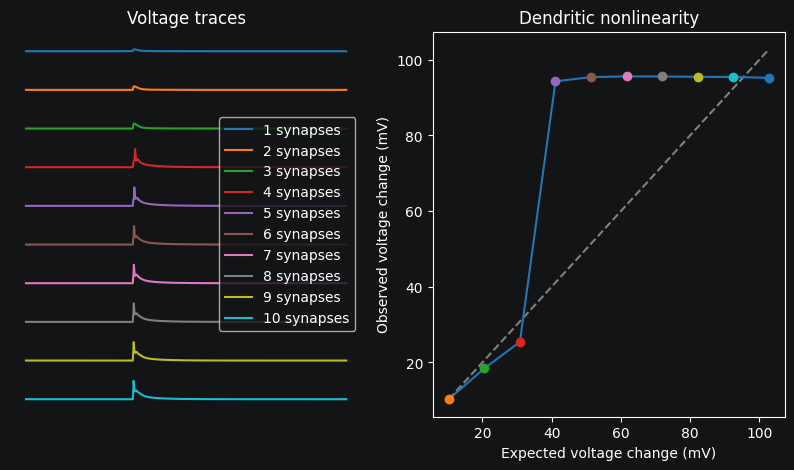

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
data = calculate_dendritic_nonlinearity(model, duration=300, max_weight=10, n=10)
plot_dendritic_nonlinearity(data, ax=ax)
ax[0].legend(loc='right')


## Standardization

In [68]:
model.remove_all_stimuli()
model.remove_all_recordings()

model.add_recording(soma, loc=0.5)
model.add_iclamp(soma, loc=0.5, amp=0.162, delay=50, dur=900)

Recording added to sec NeuronSection(idx=0) at loc 0.5.
IClamp added to sec NeuronSection(idx=0) at loc 0.5.


Detected 7 spikes
Average spike half-width: 0.97 ms
Average spike amplitude: 79.03 mV
Spike frequency: 7.78 Hz


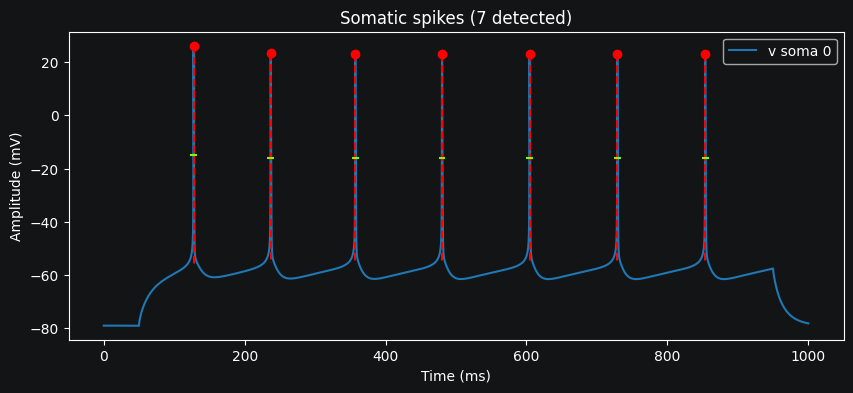

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
model.simulator.run(1000);
model.simulator.plot_voltage(ax=ax)
spike_data = detect_somatic_spikes(model)
plot_somatic_spikes(spike_data, ax, show_metrics=True)
t, v_orig = model.simulator.t, model.simulator.recordings['v'][soma(0.5)]

Got data for v in range -100.0 to 100.0 at 37°C
Got data for v in range -100.0 to 100.0 at 23°C


(model.py, line 617)


Saved content to /home/roman/Documents/code/DendroTweaksLab/DendroTweaks/examples/Park_2019/biophys/mod/stdNa.mod
Loading mechanism stdNa to NEURON...
Compiling mechanism "stdNa"...
Compilation successful.
/home/roman/Documents/code/DendroTweaksLab/DendroTweaks/examples/Park_2019/biophys/mod/stdNa
Mod files: "./stdNa.mod"

Creating 'x86_64' directory for .o files.

 -> Compiling mod_func.cpp
 -> NMODL ../stdNa.mod
 -> Compiling stdNa.c
 => LINKING shared library ./libnrnmech.so
 => LINKING executable ./special LDFLAGS are:    -pthread
Successfully created x86_64/special

Loaded mechanism "stdNa"
Got data for v in range -100.0 to 100.0 at 37°C


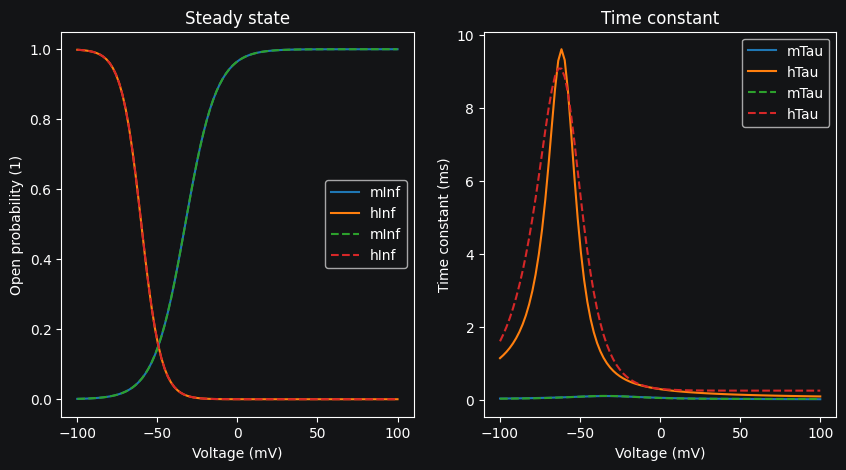

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
model.mechanisms['Na'].plot_kinetics(ax=ax)
model.standardize_channel('Na');
model.mechanisms['stdNa'].plot_kinetics(ax=ax, linestyle='--')

Got data for v in range -100.0 to 100.0 at 37°C
Got data for v in range -100.0 to 100.0 at 23°C


(model.py, line 617)


Saved content to /home/roman/Documents/code/DendroTweaksLab/DendroTweaks/examples/Park_2019/biophys/mod/stdKv.mod
Loading mechanism stdKv to NEURON...
Compiling mechanism "stdKv"...
Compilation successful.
/home/roman/Documents/code/DendroTweaksLab/DendroTweaks/examples/Park_2019/biophys/mod/stdKv
Mod files: "./stdKv.mod"

Creating 'x86_64' directory for .o files.

 -> Compiling mod_func.cpp
 -> NMODL ../stdKv.mod
 -> Compiling stdKv.c
 => LINKING shared library ./libnrnmech.so
 => LINKING executable ./special LDFLAGS are:    -pthread
Successfully created x86_64/special

Loaded mechanism "stdKv"
Got data for v in range -100.0 to 100.0 at 37°C


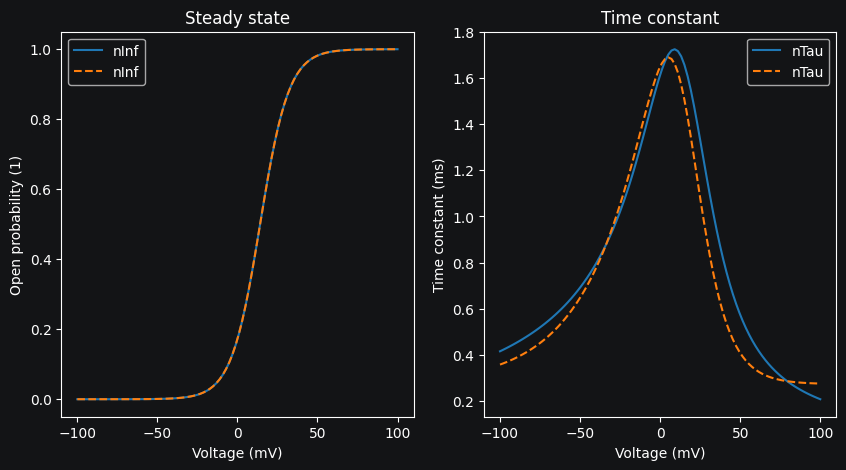

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
model.mechanisms['Kv'].plot_kinetics(ax=ax)
model.standardize_channel('Kv');
model.mechanisms['stdKv'].plot_kinetics(ax=ax, linestyle='--')

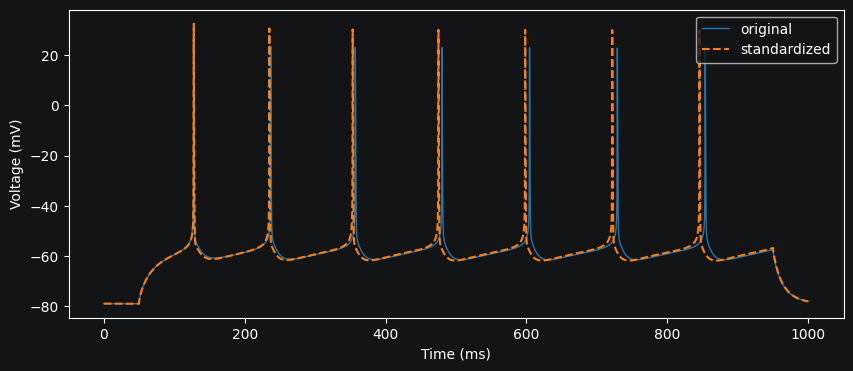

In [72]:
model.simulator.run(1000);
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
# original
ax.plot(t, v_orig, color='C0', linestyle='-', zorder=0, lw=1, label='original')
# standardized
model.simulator.plot_voltage(ax=ax, linestyle='--', color='C1')
ax.legend(labels=['original', 'standardized'], loc='upper right')

In [73]:
end_time = time.time()
print(f"Total execution time: {end_time - start_time:.2f} seconds")

Total execution time: 122.22 seconds
